# ML --- Image Classification and Image Meta Data Report

## What is the goal of this notebook
The purposes of this notebook are:
-  It provides object classification via yolo3v and ImageNet.
- It creates an Classifcation-Meta-Data Report based on the extracted data as a Pandas DataFrame. The first part of this report was done in the ETL notebook before. This report will be the main output for the web app.

## How is the Data collected?
The photo classification is realized in two different approaches:
1. by using a [yolov3 object detection](https://pjreddie.com/darknet/yolo/) algorithm. Here, I am using yolov3 pretrained weights. Deep Learning Inference with own images enables a detection of up to 80 different classes within one image. A boundary box with a class description is provided 
2. by using a convolutional neural network (CNN) based on a pretrained model from Torchvision via Transfer Learning. As a standard [VGG16](https://neurohive.io/en/popular-networks/vgg16/) is chosen. However, you can replace VGG16 by any other torchvision model. VGG16 is using the whole [ImageNet classification system](http://www.image-net.org/), The total number of classes is 1000. The file **data/imagenet_classes.txt** provides a dictionary of all one 1000 classes. The contetn of this file is also listed in the appendix of this notebook

## How is the output of this notebook organized
- The main output is a Pandas DataFrame stored as a csv file '***images.pkl***'. The first part of this report was done in the ETL notebook before (1_ETL_around_the_world_clssifier.ipynb, outcome stored there under '***images_meta.pkl***'). This DataFrame will be used by the web app. The DataFrame contains classification and meta data information of your whole image set. The web app uses this information to show the user correponding images based on his search criteria.
- In adition, the classification-Meta-Data report will be exported as an html table with thumbnail images (***images.html***)
- Images detected by Yolo are stored with object boundaries in a separate folder called **images_yolo**.
- Images with one or more persons detected by Yolo are addionally stored in a folder called ***images_personal***. This subset will be the base for future projects CNN based classifier projects for personal detection (see below) 

- A as well as stored in an html table (**your_image_folder_name.html**).

## What will be done in the future?
In the future will be implemented:
- a third  CNN based classifier with a layer combination of three times 'Conv-ReLU-MaxPool'. This approach should be deeply enough for sufficient feature extraction and for an appropriate image size/feature reduction. The goal of this CNN is to filter peronalized images, e.g. to identify images of yourself. However, for this classification step you have to provide a dataset of at least 500 personolized images. This CNN will be not pretrained. 


## IMPORTANT NOTICE:
- You have to do the image ETL preprocessing step before you can use this notebbok. Open the notebook 1_ETL_around_the_world_classifier.ipynb, provide an image directory path and run the notebook. This will provide the neccessary ETL outputs which is needed here. 

## Content
### <a href='#class_part'>Prepare Classification</a>
- <a href='#part_a_1'>Libraries</a>
- <a href='#part_a_2'>Path setting</a>
- <a href='#part_a_4'>Yolov3</a>
- <a href='#part_a_5'>ImageNet</a>
- <a href='#part_a_7'>HTML thumbnail view</a>

### <a href='#all_part'>Put all together</a>
- <a href='#all_reset'>Reset dictionary </a>
- <a href='#all_ana'>Start analayzing the data</a>
- <a href='#all_class'>The Classification Loop</a>
- <a href='#all_concat'>Concat DataFrames: Classification + Meta</a>

### <a href='#report_part'>Classification-Meta-Data Report</a>
- <a href='#rep_export'>Export report as pickle file</a>
- <a href='#rep_thumb'>Convert report to HTML with thumbnail images</a>
- <a href='#rep_html'>Export report as HTML file</a>

### <a href='#appendix'>Appendix - Yolo and ImageNet classes</a>

<a id='part_a_1'></a>

## Libraries

In [1]:
import os
try:
    import win32com.client
    speaker = win32com.client.Dispatch("SAPI.SpVoice")
    speaker.Speak("Let's begin")
except:
    os.system("say 'Let\'s begin")  
else: 
    print('No speak output')
   

In [2]:
# tkinter
from tkinter.filedialog import askopenfilename, askdirectory
from tkinter import *

# standard libraries
import os, sys, time, datetime, random
from glob import glob
from shutil import copyfile
from datetime import datetime, date, timedelta
import ast
import itertools
import json

import tkinter

# standard data science libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle   
from matplotlib.pyplot import imshow
%matplotlib inline 

# for yolo
from data.models import *
from utils import *

# for ImageNet classification using VGG16
import torch
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from torch.autograd import Variable

# for images 
import PIL
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

# for GMPAS
import gmaps
import gmaps.datasets
gmaps.configure(api_key='')

# ipywidgets
import ipywidgets as widgets
from ipywidgets import ToggleButton, RadioButtons, Image, VBox, HTML, Text, HBox, VBox, Layout, Dropdown
style = {'description_width': 'initial'}
#from ipyfilechooser import FileChooser
from functools import wraps

# for HTML displaying and output
from io import BytesIO
from IPython.display import Markdown, display, HTML
import base64
import io

import traceback

def printmd(string):
    display(Markdown(string))
    
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )


# current working directory
cwd = os.path.abspath(os.getcwd())
print(cwd)

/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data


<a id='part_a_2'></a>

## Path setting
- Check path settings done in 1_ETL_around_the_world_classifier.ipynb
- Its path setting is the baseline here
- images_meta.pkl (file in the same directory like this notebook, produced during the ETL process) will be read

In [3]:
# Read image.pkl
df_meta = pd.read_pickle('images_meta.pkl')
df_meta

,path_to_file,file,readable,date_time,orientation,width,height,rotation_angle,flip,GPS,state_after_rot
3,/Users/davidhartmann/Documents/Udacity/Data_Sc...,1.jpg,True,2019-03-19 10:35:48,1,4032,3024,0,NO,"(55.86449189238991, -4.4298895959595965)",no change
2,/Users/davidhartmann/Documents/Udacity/Data_Sc...,2.jpg,True,2019-03-19 10:51:33,1,4032,3024,0,NO,"(55.86182953710507, -4.41538315539739)",no change
0,/Users/davidhartmann/Documents/Udacity/Data_Sc...,3.jpg,True,2019-03-19 10:57:03,1,4032,3024,0,NO,"(55.84993888888889, -4.287311111111111)",no change
5,/Users/davidhartmann/Documents/Udacity/Data_Sc...,4.jpg,True,2019-03-19 11:57:46,1,4032,3024,0,NO,"(55.913596908117555, -4.435347215371631)",no change
7,/Users/davidhartmann/Documents/Udacity/Data_Sc...,5.jpg,True,2019-03-19 11:57:49,1,4032,3024,0,NO,"(55.91388110002696, -4.435910787253153)",no change
8,/Users/davidhartmann/Documents/Udacity/Data_Sc...,6.jpg,True,2019-03-19 11:59:25,1,4032,3024,0,NO,"(55.91922085170114, -4.45444038380557)",no change
4,/Users/davidhartmann/Documents/Udacity/Data_Sc...,7.jpg,True,2019-03-19 11:59:45,1,4032,3024,0,NO,"(55.9205553371768, -4.4553684646321265)",no change
1,/Users/davidhartmann/Documents/Udacity/Data_Sc...,8.jpg,True,2019-03-19 11:59:47,1,4032,3024,0,NO,"(55.92055711955671, -4.455367932413876)",no change
6,/Users/davidhartmann/Documents/Udacity/Data_Sc...,9.jpg,True,2019-03-19 12:00:41,1,4032,3024,0,NO,"(55.9251239190332, -4.458130830086197)",no change


<a id='part_a_4'></a>

## Yolov3
### Yolov3 - model, weights and classes load
- Read in yolo weights 
- Read in the Yolo pretrained model
- Read in Yolo labels

In [4]:
config_path = os.path.join(cwd, 'data', 'config', 'yolov3.cfg')
weights_path = os.path.join(cwd, 'data', 'config', 'yolov3.weights')
class_path =  os.path.join(cwd, 'data', 'config', 'coco.names')
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)

#model.cuda()
model.eval()

# Yolo labels / classes 
classes_yolo = utils.load_classes(class_path)
Tensor = torch.FloatTensor

/anaconda3/envs/atw_macOS/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### Yolov3 - Image inference 

In [5]:
def detect_image(img):
    """ Scale & pad image
        Convert image to tensor 
        Run inference on the model and get detections
        
        INPUTS:
        ------------
            img - (PIL.Image object) - single image which shoulfd be classifed with Yolo
        
        OUTPUTS:
        ------------
            detections - (list) list of observed labels
    """
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

### Yolov3 - Bounding boxes based on detection 

In [6]:
### load image and get detections
def yolo_detector(img_path):
    """ Create boundary boxes around detected objects on images
    
        INPUTS:
        ------------
            img_path - (string) the full absolute path to the image
        
        OUTPUTS:
        ------------
            classes_yolo_found - (list) a list of detecte4d labels
            save_path_yolo - (string) path to the image with overlayed boundary boxes
    """
    
    # get PIL.Image object
    img = PIL.Image.open(img_path)
    try: 
        detections = detect_image(img)
    except:
        detections = None
    

    # Get bounding-box colors
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    img = np.array(img)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    classes_yolo_found = []
    if detections is not None:
        
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        # browse detections and draw bounding boxes
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
            x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(bbox)
            plt.text(x1, y1, s=classes_yolo[int(cls_pred)], color='white', verticalalignment='top',
                    bbox={'color': color, 'pad': 0})
            classes_yolo_found.append(classes_yolo[int(cls_pred)])
        
    plt.axis('off')
    # save image
    save_path_yolo = ''
    if classes_yolo_found != []:
        head, tail = os.path.split(img_path)
        save_path_yolo = os.path.join(yolo_folder, tail)
        print('save_path_yolo: ', save_path_yolo)
        plt.savefig(save_path_yolo, bbox_inches='tight', pad_inches=0.0)
    plt.cla()
    plt.close(fig)
    return classes_yolo_found, save_path_yolo

<a id='part_a_5'></a>

## ImageNet

### ImageNet - Load labels of ImageNet from file

In [7]:
with open('data/imagenet_classes.txt') as f:
  classes_ImageNet = [line.strip().replace('\"', '').split(',') for line in f.readlines()]

classes_ImageNet  = [[element.lstrip().replace(' ', '_') for element in l] for l in classes_ImageNet]
print(classes_ImageNet)

labels = dict(enumerate(classes_ImageNet))

print(labels)

[['tench', 'Tinca_tinca'], ['goldfish', 'Carassius_auratus'], ['great_white_shark', 'white_shark', 'man-eater', 'man-eating_shark', 'Carcharodon_carcharias'], ['tiger_shark', 'Galeocerdo_cuvieri'], ['hammerhead', 'hammerhead_shark'], ['electric_ray', 'crampfish', 'numbfish', 'torpedo'], ['stingray'], ['cock'], ['hen'], ['ostrich', 'Struthio_camelus'], ['brambling', 'Fringilla_montifringilla'], ['goldfinch', 'Carduelis_carduelis'], ['house_finch', 'linnet', 'Carpodacus_mexicanus'], ['junco', 'snowbird'], ['indigo_bunting', 'indigo_finch', 'indigo_bird', 'Passerina_cyanea'], ['robin', 'American_robin', 'Turdus_migratorius'], ['bulbul'], ['jay'], ['magpie'], ['chickadee'], ['water_ouzel', 'dipper'], ['kite'], ['bald_eagle', 'American_eagle', 'Haliaeetus_leucocephalus'], ['vulture'], ['great_grey_owl', 'great_gray_owl', 'Strix_nebulosa'], ['European_fire_salamander', 'Salamandra_salamandra'], ['common_newt', 'Triturus_vulgaris'], ['eft'], ['spotted_salamander', 'Ambystoma_maculatum'], ['ax

### ImageNet - Define the pretrained model for image classification

In [8]:
# define model
model_ImageNet = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    model_ImageNet = model_ImageNet.cuda()
    print('CUDA is available!  Training on GPU ...')
    
else:
    print('CUDA is not available.  Training on CPU ...')

    
print(' ')
print(model_ImageNet)

CUDA is not available.  Training on CPU ...
 
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(

### ImageNet - Tensor transformations

In [9]:
# Do necessary transformations to get the right image tensors
def transform_to_tensor(img_path):
    """ Transform image to enhance Deep Learning 
        - Resize it
        - Crop image at the center
        - Transform it to PyTorch tensor
        - Normalize it with standard value set
        
        INPUTS:
        ------------
            img_path - (string) the full absolute path to the image
        
        OUTPUTS:
        ------------
            image - (Tensor) a trasnformed tensor
    """
    transform_img_size = 224
    transform_crop = 224
    transform = transforms.Compose([transforms.Resize(transform_img_size),
                                    transforms.CenterCrop(transform_crop),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
    
    # load the image
   
    image = PIL.Image.open(img_path).convert('RGB')  # Read bytes and store as an img.
    image = transform(image)[:3,:,:]

    # PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
    # Currently however, there is (num color channels, height, width); let's fix this by inserting a new axis.
    image = image.unsqueeze(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims. 
    
    return image

### ImageNet - Convert from tensor image to numpy image for displaying 

In [10]:
# Converting a Tensor image to a NumPy image for displaying
def im_convert(tensor):
    """ Convert PyTorch tensor back to numpy array if you want to display it with matplotlib
    
        INPUTS:
        ------------
            tensor (tensor) a PyTorch input tensor 
            
        OUTPUTS:
        ------------
            image (numpy array) image as numpy array for displaying with matplotlib
    """
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

### ImageNet - Prediction function based on the used model

In [11]:
# Prediction function based on the model
def model_predict(img_path):
    ''' Use pre-trained VGG-16 model to obtain index corresponding to 
        predicted ImageNet class for image at specified path
    
        INPUTS:
        ------------
            img_path (string) path to an image
        
        OUTPUTS:
        ------------
            preds_tensor - (int) index of the class label with the largest value
            possible_classes - (list) possible predicted ImageNet classes predicted via VGG16
            
    '''
    
    # Load and pre-process an image from the given img_path
    # Return the *index* of the predicted class for that image
    # Return list of tuples --> [([most common classes], probability)]
    
    model_ImageNet.eval()
    # Implement image transformations
    img = transform_to_tensor(img_path)
        
    # get sample outputs
    try:
        output = model_ImageNet(img)  # Returns a Tensor of shape (batch, num class labels)
        _, preds_tensor = torch.max(output, 1)  # Our prediction will be the index of the class label with the largest value.
        #print(labels[prediction])  # Converts the index to a string using our labels dict
    
        percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
        _, indices = torch.sort(output, descending=True)
        possible_classes = [(labels[int(idx)], percentage[int(idx)].item()) for idx in indices[0][:5]]
    
    except:
        possible_classes = []
        preds_tensor = None
    return preds_tensor, possible_classes # predicted class index and list of labels

<a id='part_a_6'></a>

<a id='part_a_7'></a>

## HTML thumbnail view

### Prepare images for thumbnail view in DataFrame

In [12]:
def check_file_path(row):
    """ Check if Yolo image exists. return True if Yes, False if not.
        This 'True and False definition' is needed to create successfully thumbnail images.
        This should be done ONLY if the Yolo Image exists. Otherwise an error would occur.
        
        INPUTS:
        ------------
            row - ( pandas Series) actual chosen row of the classification report DataFrame
            
        
        OUTPUTS:
        ------------
            True/False - (bool) if Yolo image in that row exist, False if not 
             
    """
    
    try:
        return os.path.isfile(row)
    except:
        return False

In [13]:
pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    """ Create a thumbnail image for the actual chosen image
        
        INPUTS:
        ------------
            path - (string) the CORRECTED path to the actual image
        
        OUTPUTS:
        ------------
            i (Image) a thumbnail image for the actual image
    """
   
    i = PIL.Image.open(path)
    #i.resize((300, 300),  PIL.Image.LANCZOS)
    i.thumbnail((300, 300), PIL.Image.ANTIALIAS)
    return i

"""
FUNKTIONIERT AUF IMAC
def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
        
def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'
"""

def image_base64(im):
    """ Helper function for image_formatter()
        
        INPUTS:
        ------------
            im - (Image) an Image object 
        
        OUTPUTS:
        ------------
            base64.b64encode(buffer.read()).decode('ascii') - (string) a readable HTML src path
    """
    
    
    buffer = io.BytesIO()
    im = im.convert("RGBA")
    im.save(buffer, format='PNG')
    buffer.seek(0)

    return base64.b64encode(buffer.read()).decode('ascii')


def image_formatter(im):
    """ Convert image back to a readable html tag for the browser
        
        INPUTS:
        ------------
            im - (Image) an Image object 
        
        OUTPUTS:
        ------------
            html_img (string) an html tag for browser displaying
    """
    
    html_img = f'<img src="data:image/jpeg;base64,{image_base64(im)}">'
    return html_img

<a id='all_part'></a>

## Putting all together: 

<a id='all_reset'></a>

### Reset dictionary 

In [14]:
def reset_dict():
    """ Reset dict - base for DataFrame df_class
    
        INPUTS:
        -----------
            None
        
        OUTPUTS:
        ------------ 
            dict - (dictionary) a reset dictionary to store image classification results
    """
    dict = {'path_to_file' : [],
            'file' : [],
            'img_path_yolo' : [],
            #'image' : [],
            #'image_yolo' : [],
            'classes_yolo' : [],
            'classes_ImgNet' : [],
            'classes_ImgNet_idx' : [],
            'class_ImgNet_add' : []
           }
    return dict

<a id='all_ana'></a>

### Start analayzing the data

In [15]:
try:
    speaker.Speak("I start the classification process")
    #speaker.Speak("I start the classification process")
    
except:
    #os.system("say 'I start the classification process'")
    os.system("say 'I start the classification process'")

else: 
    print('I start the classification process')
    

<a id='all_class'></a>

### The Classification Loop

- This is the main loop for Yolo and ImageNet classifcation. 
- The baseline is the df_meta (images_meta.pkl from the ETL notebook)
- All images are checked one by one make a prediction based on Yolo and VGG16
- 

In [16]:
dict = reset_dict()
root = df_meta['path_to_file'].tolist()
person_folder = './images_personal'
yolo_folder = './images_yolo'
file_count = 0
try: 
    for img_path in root[:10]:
        path_to_file, file = os.path.split(img_path)
        """
        img path
        """
        print('img_path: ', img_path)
    
        """
        Yolo detection
        """
        classes_yolo_found, save_path_yolo = yolo_detector(img_path)

        """
        classification
        """
        print('classes_yolo: ', classes_yolo_found)
        if 'person' in classes_yolo_found:
            print("person found!")
            
            # copy imnages with human beings in a separate folder for personal labeling (future project)
            print('person_folder: ', person_folder)
            dest_path = os.path.join(person_folder, file)
            copyfile(img_path, dest_path)
            print('dest_path: ', dest_path)
        
        
        # get Yolo prediction reults back
        preds_as_tensor, possible_classes = model_predict(img_path)
        
        # in case preds_as_tensor is not null --> show the prediction result
        if preds_as_tensor:
            pred_index = np.squeeze(preds_as_tensor.numpy()) if not use_cuda else np.squeeze(preds_as_tensor.cpu().numpy())
            print('classes_ImageNet: ', labels[int(pred_index)])
            print('classes_ImageNet_add: ', possible_classes)
        else:
            pred_index = None
            print('classes_ImageNet: []')
            print('classes_ImageNet_add: []')
        print('--------------------------------------------------------------------')
        
        # Update the dictionary --> store the findings -->
        dict['path_to_file'].append(img_path) 
        dict['file'].append(file)
        dict['img_path_yolo'].append(save_path_yolo)
        #dict['image'].append(get_thumbnail(img_path))

        #if save_path_yolo != '':
        #    dict['image_yolo'].append(get_thumbnail(save_path_yolo))
        #else:
        #    dict['image_yolo'].append(None)
            
        dict['classes_yolo'].append(classes_yolo_found)

        if pred_index != None:
            dict['classes_ImgNet'].append(labels[int(pred_index)])
            dict['classes_ImgNet_idx'].append(int(pred_index))
        else:
            dict['classes_ImgNet'].append(None)
            dict['classes_ImgNet_idx'].append(None)
        dict['class_ImgNet_add'].append(possible_classes)

        if file_count == 20:
            try:
                #speaker.Speak("Bild Nummer " + str(round_count))
                speaker.Speak("Image number" + str(round_count))
            except:
                #os.system("say 'Bild Nummer: {}'".format(str(round_count)))
                os.system("say 'Image number: {}'".format(str(round_count)))
            else: 
                print('Image number: {}'.format(str(round_count)))
        file_count += 1
        
except Exception as e: 
    #print(e)
    traceback.print_exc()
    try:
        #speaker.Speak("Ein Fehler ist aufgetreten!")
        speaker.Speak("An error occured!")

    except:
        os.system("say 'An error occured!'")
        #os.system("Ein Fehler ist aufgetreten!")
 
    else: 
        print('An error occured!')

img_path:  /Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/1.jpg
save_path_yolo:  ./images_yolo/1.jpg
classes_yolo:  ['person', 'person']
person found!
person_folder:  ./images_personal
dest_path:  ./images_personal/1.jpg
classes_ImageNet:  ['street_sign']
classes_ImageNet_add:  [(['street_sign'], 22.165002822875977), (['moving_van'], 11.253789901733398), (['wing'], 8.379040718078613), (['traffic_light', 'traffic_signal', 'stoplight'], 6.293417453765869), (['ambulance'], 5.369166851043701)]
--------------------------------------------------------------------
img_path:  /Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/2.jpg
save_path_yolo:  ./images_yolo/2.jpg
classes_yolo:  ['car', 'car', 'car', 'car', 'car']
classes_ImageNet:  ['car_mirror']
classes_ImageNet_add:  [(['car_mirror'], 19.255046844482422), (['minivan'], 15.607881546020508), (['limousine', 'limo'], 13.92467212677002), (['wing'], 13.895726203918457), (

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [17]:
try:
    speaker.Speak("I have finished the classification process")
    #speaker.Speak("I start the classification process")
    
except:
    #os.system("say 'I start the classification process'")
    os.system("say 'I have finished the classification process'")

else: 
    print('I have finished the classification process')

<a id='all_concat'></a>

### Concat DataFrames: Classification + Meta

- Now concat df_meta from the ETL step with the new classification results
- In doing so, convert dict to a DataFrame df_class
- Concat df_meta with df_class to get df_class_meta

#### Important notice: For github upload only a short slice of 10 pictures will be taken in this demo

In [18]:
##########################################################
# Remove the slice  of df_meta to get the full dataframe #
##########################################################
df_meta_test = df_meta.iloc[:10,:]

# set file as index in order to concat df_meta with df_class on that index
df_meta_test.set_index('file', inplace=True)

# convert dict to a dataframe
df_class = pd.DataFrame(dict)

# set file as index in order to concat df_meta with df_class on that index
df_class.set_index('file', inplace=True)

# drop path to file in df_class
df_class.drop('path_to_file', inplace=True, axis=1)

#display(df_ml_test)
#display(df_class)

# Concat df_meta and df_class 
df_class_meta = pd.concat([df_meta_test, df_class], axis=1)

# Reset 'file' again to a column 
df_class_meta.reset_index(inplace=True)

try:
    del df_class_meta['Unneamed: 0']
except:
    pass

# show the result
display(df_class_meta)

,file,path_to_file,readable,date_time,orientation,width,height,rotation_angle,flip,GPS,state_after_rot,img_path_yolo,classes_yolo,classes_ImgNet,classes_ImgNet_idx,class_ImgNet_add
0,1.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/1.jpg,True,2019-03-19 10:35:48,1,4032,3024,0,NO,"(55.86449189238991, -4.4298895959595965)",no change,./images_yolo/1.jpg,"[person, person]",[street_sign],919,"[([street_sign], 22.165002822875977), ([moving_van], 11.253789901733398), ([wing], 8.379040718078613), ([traffic_light, traffic_signal, stoplight], 6.293417453765869), ([ambulance], 5.369166851043701)]"
1,2.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/2.jpg,True,2019-03-19 10:51:33,1,4032,3024,0,NO,"(55.86182953710507, -4.41538315539739)",no change,./images_yolo/2.jpg,"[car, car, car, car, car]",[car_mirror],475,"[([car_mirror], 19.255046844482422), ([minivan], 15.607881546020508), ([limousine, limo], 13.92467212677002), ([wing], 13.895726203918457), ([convertible], 11.028861045837402)]"
2,3.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/3.jpg,True,2019-03-19 10:57:03,1,4032,3024,0,NO,"(55.84993888888889, -4.287311111111111)",no change,./images_yolo/3.jpg,"[car, car, car]","[traffic_light, traffic_signal, stoplight]",920,"[([traffic_light, traffic_signal, stoplight], 21.303001403808594), ([trailer_truck, tractor_trailer, trucking_rig, rig, articulated_lorry, semi], 13.868844985961914), ([passenger_car, coach, carriage], 6.869407653808594), ([freight_car], 5.0408477783203125), ([streetcar, tram, tramcar, trolley, trolley_car], 4.72355318069458)]"
3,4.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/4.jpg,True,2019-03-19 11:57:46,1,4032,3024,0,NO,"(55.913596908117555, -4.435347215371631)",no change,./images_yolo/4.jpg,"[car, car, car, car]","[traffic_light, traffic_signal, stoplight]",920,"[([traffic_light, traffic_signal, stoplight], 34.03543472290039), ([streetcar, tram, tramcar, trolley, trolley_car], 10.615340232849121), ([trolleybus, trolley_coach, trackless_trolley], 3.8722434043884277), ([car_mirror], 3.1056997776031494), ([mobile_home, manufactured_home], 2.8439457416534424)]"
4,5.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/5.jpg,True,2019-03-19 11:57:49,1,4032,3024,0,NO,"(55.91388110002696, -4.435910787253153)",no change,./images_yolo/5.jpg,"[car, car, car, car, car, car, car, truck]","[traffic_light, traffic_signal, stoplight]",920,"[([traffic_light, traffic_signal, stoplight], 26.575984954833984), ([triumphal_arch], 11.212915420532227), ([car_mirror], 6.99009370803833), ([minivan], 4.328091621398926), ([limousine, limo], 3.8021080493927)]"
5,6.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/6.jpg,True,2019-03-19 11:59:25,1,4032,3024,0,NO,"(55.91922085170114, -4.45444038380557)",no change,,[],[pole],733,"[([pole], 82.6746826171875), ([street_sign], 2.7583441734313965), ([shovel], 2.6784934997558594), ([flagpole, flagstaff], 2.6066832542419434), ([totem_pole], 1.7437785863876343)]"
6,7.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/7.jpg,True,2019-03-19 11:59:45,1,4032,3024,0,NO,"(55.9205553371768, -4.4553684646321265)",no change,,[],[boathouse],449,"[([boathouse], 24.7222900390625), ([barn], 12.32899284362793), ([greenhouse, nursery, glasshouse], 11.944051742553711), ([worm_fence, snake_fence, snake-rail_fence, Virginia_fence], 8.115385055541992), ([thatch, thatched_roof], 6.820980548858643)]"
7,8.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/8.jpg,True,2019-03-19 11:59:47,1,4032,3024,0,NO,"(55.92055711955671, -4.455367932413876)",no change,./images_yolo/8.jpg,[traffic light],"[thatch, thatched_roof]",853,"[([thatch, thatched_roof], 37.70661163330078), ([greenhouse, nursery, glasshouse], 25.484678268432

<a id='report_part'></a>

## Classification-Meta-Data Report

<a id='rep_export'></a>

### Export report as pickle file

In [19]:
# Export df_class_meta as a pickle file
df_class_meta.to_pickle('images.pkl')

<a id='rep_thumb'></a>

### Convert report to HTML with thumbnail images

,file,path_to_file,readable,date_time,orientation,width,height,rotation_angle,flip,GPS,state_after_rot,img_path_yolo,classes_yolo,classes_ImgNet,classes_ImgNet_idx,class_ImgNet_add,image,image_yolo
0,1.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/1.jpg,True,2019-03-19 10:35:48,1,4032,3024,0,NO,"(55.86449189238991, -4.4298895959595965)",no change,./images_yolo/1.jpg,"[person, person]",[street_sign],919,"[([street_sign], 22.165002822875977), ([moving_van], 11.253789901733398), ([wing], 8.379040718078613), ([traffic_light, traffic_signal, stoplight], 6.293417453765869), ([ambulance], 5.369166851043701)]",,
1,2.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/2.jpg,True,2019-03-19 10:51:33,1,4032,3024,0,NO,"(55.86182953710507, -4.41538315539739)",no change,./images_yolo/2.jpg,"[car, car, car, car, car]",[car_mirror],475,"[([car_mirror], 19.255046844482422), ([minivan], 15.607881546020508), ([limousine, limo], 13.92467212677002), ([wing], 13.895726203918457), ([convertible], 11.028861045837402)]",,
2,3.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/3.jpg,True,2019-03-19 10:57:03,1,4032,3024,0,NO,"(55.84993888888889, -4.287311111111111)",no change,./images_yolo/3.jpg,"[car, car, car]","[traffic_light, traffic_signal, stoplight]",920,"[([traffic_light, traffic_signal, stoplight], 21.303001403808594), ([trailer_truck, tractor_trailer, trucking_rig, rig, articulated_lorry, semi], 13.868844985961914), ([passenger_car, coach, carriage], 6.869407653808594), ([freight_car], 5.0408477783203125), ([streetcar, tram, tramcar, trolley, trolley_car], 4.72355318069458)]",,
3,4.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/4.jpg,True,2019-03-19 11:57:46,1,4032,3024,0,NO,"(55.913596908117555, -4.435347215371631)",no change,./images_yolo/4.jpg,"[car, car, car, car]","[traffic_light, traffic_signal, stoplight]",920,"[([traffic_light, traffic_signal, stoplight], 34.03543472290039), ([streetcar, tram, tramcar, trolley, trolley_car], 10.615340232849121), ([trolleybus, trolley_coach, trackless_trolley], 3.8722434043884277), ([car_mirror], 3.1056997776031494), ([mobile_home, manufactured_home], 2.8439457416534424)]",,
4,5.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/5.jpg,True,2019-03-19 11:57:49,1,4032,3024,0,NO,"(55.91388110002696, -4.435910787253153)",no change,./images_yolo/5.jpg,"[car, car, car, car, car, car, car, truck]","[traffic_light, traffic_signal, stoplight]",920,"[([traffic_light, traffic_signal, stoplight], 26.575984954833984), ([triumphal_arch], 11.212915420532227), ([car_mirror], 6.99009370803833), ([minivan], 4.328091621398926), ([limousine, limo], 3.8021080493927)]",,
5,6.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/6.jpg,True,2019-03-19 11:59:25,1,4032,3024,0,NO,"(55.91922085170114, -4.45444038380557)",no change,,[],[pole],733,"[([pole], 82.6746826171875), ([street_sign], 2.7583441734313965), ([shovel], 2.6784934997558594), ([flagpole, flagstaff], 2.6066832542419434), ([totem_pole], 1.7437785863876343)]",,None
6,7.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/7.jpg,True,2019-03-19 11:59:45,1,4032,3024,0,NO,"(55.9205553371768, -4.4553684646321265)",no change,,[],[boathouse],449,"[([boathouse], 24.7222900390625), ([barn], 12.32899284362793), ([greenhouse, nursery, glasshouse], 11.944051742553711), ([worm_fence, snake_fence, snake-rail_fence, Virginia_fence], 8.115385055541992), ([thatch, thatched_roof], 6.820980548858643)]",,None
7,8.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/8.jpg,True,2019-03-19 11:59:47,1,4032,3024,0,NO,"(55.92055711955671, -4.455367932413876)",no change,./images_yolo/8.jpg,[traffic light],"[thatch, thatched_roof]",853,"[([thatch, thatched_roof], 37.70661163330078), ([greenhouse
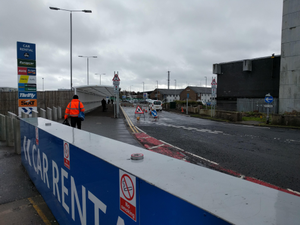
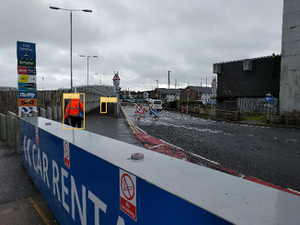
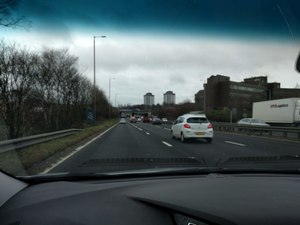
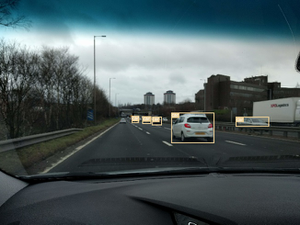
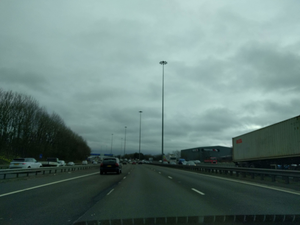
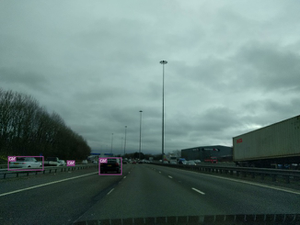
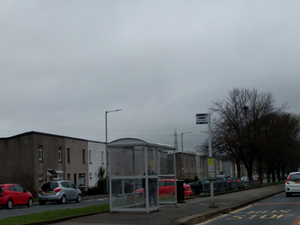
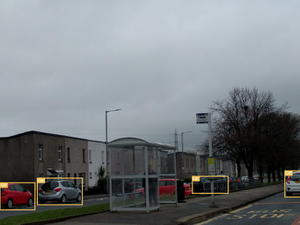
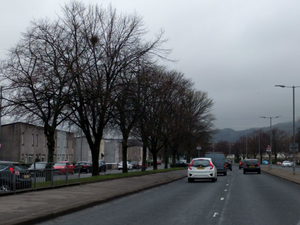
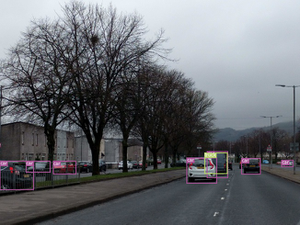
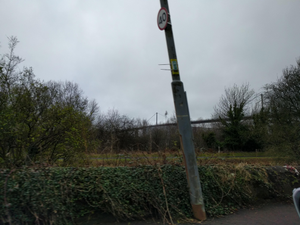
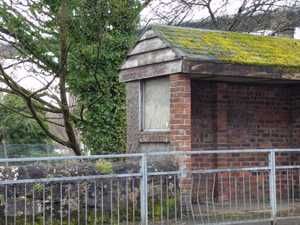
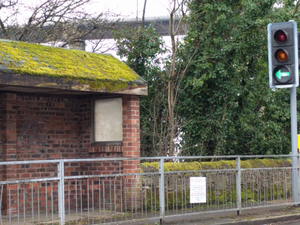
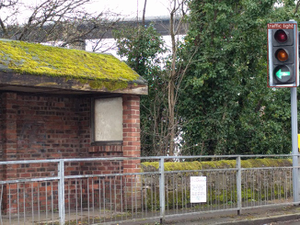
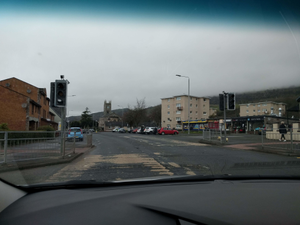
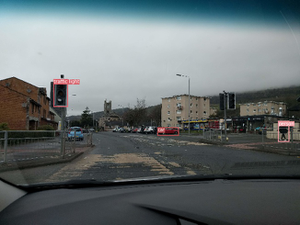

In [20]:
df_class_meta['image'] = df_class_meta.apply(lambda row: get_thumbnail(row['path_to_file']), axis = 1)
df_class_meta['exists'] = df_class_meta.apply(lambda row: check_file_path(row['img_path_yolo']), axis = 1)
df_class_meta['image_yolo'] = df_class_meta.apply(lambda row: get_thumbnail(row['img_path_yolo']) if row['exists'] == True else None, axis = 1)

try: 
    df_class_meta.drop('exists', inplace =True, axis=1)
except:
    pass

# Convert DataFrame to HTML, displaying PIL.Image objects embedded in dataframe
a=HTML(df_class_meta.to_html(formatters={'image': image_formatter, 'image_yolo': image_formatter}, escape=False))
a

<a id='rep_html'></a>

### Export report as HTML file

In [21]:
# Export df_class_meta  with thumbnail images as a html file
from IPython.core.display import HTML
html = a.data
with open('images.html', 'w') as f:
    f.write(html)

<a id='appendix'></a>

### Appendix - Yolo and ImageNet classes

##### yolo classes:

- person
- bicycle, car, motorbike, aeroplane, bus, train, truck, boat
- traffic light, fire hydrant, stop sign, parking meter, bench
- cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe
- backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket
- bottle, wine glass, cup, fork, knife, spoon, bowl
- banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake
- chair, sofa, pottedplant, bed, diningtable, toilet, tvmonitor, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush

##### ImageNet classes:
- tench, Tinca tinca
- goldfish, Carassius auratus
- great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
- tiger shark, Galeocerdo cuvieri
- hammerhead, hammerhead shark
- electric ray, crampfish, numbfish, torpedo
- stingray
- cock
- hen
- ostrich, Struthio camelus
- brambling, Fringilla montifringilla
- goldfinch, Carduelis carduelis
- house finch, linnet, Carpodacus mexicanus
- junco, snowbird
- indigo bunting, indigo finch, indigo bird, Passerina cyanea
- robin, American robin, Turdus migratorius
- bulbul
- jay
- magpie
- chickadee
- water ouzel, dipper
- kite
- bald eagle, American eagle, Haliaeetus leucocephalus
- vulture
- great grey owl, great gray owl, Strix nebulosa
- European fire salamander, Salamandra salamandra
- common newt, Triturus vulgaris
- eft
- spotted salamander, Ambystoma maculatum
- axolotl, mud puppy, Ambystoma mexicanuma
- bullfrog, Rana catesbeiana
- tree frog, tree-frog
- tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
- loggerhead, loggerhead turtle, Caretta caretta
- leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea
- mud turtle
- terrapin
- box turtle, box tortoise
- banded gecko
- common iguana, iguana, Iguana iguana
- American chameleon, anole, Anolis carolinensis
- whiptail, whiptail lizard
- agama
- frilled lizard, Chlamydosaurus kingi
- alligator lizard
- Gila monster, Heloderma suspectum
- green lizard, Lacerta viridis
- African chameleon, Chamaeleo chamaeleon
- Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis
- African crocodile, Nile crocodile, Crocodylus niloticus
- American alligator, Alligator mississipiensis
- triceratops
- thunder snake, worm snake, Carphophis amoenus
- ringneck snake, ring-necked snake, ring snake
- hognose snake, puff adder, sand viper
- green snake, grass snake
- king snake, kingsnake
- garter snake, grass snake
- water snake
- vine snake
- night snake, Hypsiglena torquata
- boa constrictor, Constrictor constrictor
- rock python, rock snake, Python sebae
- Indian cobra, Naja naja
- green mamba
- sea snake
- horned viper, cerastes, sand viper, horned asp, Cerastes cornutus
- diamondback, diamondback rattlesnake, Crotalus adamanteus
- sidewinder, horned rattlesnake, Crotalus cerastes
- trilobite
- harvestman, daddy longlegs, Phalangium opilio
- scorpion
- black and gold garden spider, Argiope aurantia
- barn spider, Araneus cavaticus
- garden spider, Aranea diademata
- black widow, Latrodectus mactans
- tarantula
- wolf spider, hunting spider
- tick
- centipede
- black grouse
- ptarmigan
- ruffed grouse, partridge, Bonasa umbellus
- prairie chicken, prairie grouse, prairie fowl
- peacock
- quail
- partridge
- African grey, African gray, Psittacus erithacus
- macaw
- sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita
- lorikeet
- coucal
- bee eater
- hornbill
- hummingbird
- jacamar
- toucan
- drake
- red-breasted merganser, Mergus serrator
- goose
- black swan, Cygnus atratus
- tusker
- echidna, spiny anteater, anteater
- platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus
- wallaby, brush kangaroo
- koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
- wombat
- jellyfish
- sea anemone, anemone
- brain coral
- flatworm, platyhelminth
- nematode, nematode worm, roundworm
- conch
- snail
- slug
- sea slug, nudibranch
- chiton, coat-of-mail shell, sea cradle, polyplacophore
- chambered nautilus, pearly nautilus, nautilus
- Dungeness crab, Cancer magister
- rock crab, Cancer irroratus
- fiddler crab
- king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica
- American lobster, Northern lobster, Maine lobster, Homarus americanus
- spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish
- crayfish, crawfish, crawdad, crawdaddy
- hermit crab
- isopod
- white stork, Ciconia ciconia
- black stork, Ciconia nigra
- spoonbill
- flamingo
- little blue heron, Egretta caerulea
- American egret, great white heron, Egretta albus
- bittern
- crane
- limpkin, Aramus pictus
- European gallinule, Porphyrio porphyrio
- American coot, marsh hen, mud hen, water hen, Fulica americana
- bustard
- ruddy turnstone, Arenaria interpres
- red-backed sandpiper, dunlin, Erolia alpina
- redshank, Tringa totanus
- dowitcher
- oystercatcher, oyster catcher
- pelican
- king penguin, Aptenodytes patagonica
- albatross, mollymawk
- grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus
- killer whale, killer, orca, grampus, sea wolf, Orcinus orca
- dugong, Dugong dugon
- sea lion
- Chihuahua
- Japanese spaniel
- Maltese dog, Maltese terrier, Maltese
- Pekinese, Pekingese, Peke
- Shih-Tzu
- Blenheim spaniel
- papillon
- toy terrier
- Rhodesian ridgeback
- Afghan hound, Afghan
- basset, basset hound
- beagle
- bloodhound, sleuthhound
- bluetick
- black-and-tan coonhound
- Walker hound, Walker foxhound
- English foxhound
- redbone
- borzoi, Russian wolfhound
- Irish wolfhound
- Italian greyhound
- whippet
- Ibizan hound, Ibizan Podenco
- Norwegian elkhound, elkhound
- otterhound, otter hound
- Saluki, gazelle hound
- Scottish deerhound, deerhound
- Weimaraner
- Staffordshire bullterrier, Staffordshire bull terrier
- American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier
- Bedlington terrier
- Border terrier
- Kerry blue terrier
- Irish terrier
- Norfolk terrier
- Norwich terrier
- Yorkshire terrier
- wire-haired fox terrier
- Lakeland terrier
- Sealyham terrier, Sealyham
- Airedale, Airedale terrier
- cairn, cairn terrier
- Australian terrier
- Dandie Dinmont, Dandie Dinmont terrier
- Boston bull, Boston terrier
- miniature schnauzer
- giant schnauzer
- standard schnauzer
- Scotch terrier, Scottish terrier, Scottie
- Tibetan terrier, chrysanthemum dog
- silky terrier, Sydney silky
- soft-coated wheaten terrier
- West Highland white terrier
- Lhasa, Lhasa apso
- flat-coated retriever
- curly-coated retriever
- golden retriever
- Labrador retriever
- Chesapeake Bay retriever
- German short-haired pointer
- vizsla, Hungarian pointer
- English setter
- Irish setter, red setter
- Gordon setter
- Brittany spaniel
- clumber, clumber spaniel
- English springer, English springer spaniel
- Welsh springer spaniel
- cocker spaniel, English cocker spaniel, cocker
- Sussex spaniel
- Irish water spaniel
- kuvasz
- schipperke
- groenendael
- malinois
- briard
- kelpie
- komondor
- Old English sheepdog, bobtail
- Shetland sheepdog, Shetland sheep dog, Shetland
- collie
- Border collie
- Bouvier des Flandres, Bouviers des Flandres
- Rottweiler
- German shepherd, German shepherd dog, German police dog, alsatian
- Doberman, Doberman pinscher
- miniature pinscher
- Greater Swiss Mountain dog
- Bernese mountain dog
- Appenzeller
- EntleBucher
- boxer
- bull mastiff
- Tibetan mastiff
- French bulldog
- Great Dane
- Saint Bernard, St Bernard
- Eskimo dog, husky
- malamute, malemute, Alaskan malamute
- Siberian husky
- dalmatian, coach dog, carriage dog
- affenpinscher, monkey pinscher, monkey dog
- basenji
- pug, pug-dog
- Leonberg
- Newfoundland, Newfoundland dog
- Great Pyrenees
- Samoyed, Samoyede
- Pomeranian
- chow, chow chow
- keeshond
- Brabancon griffon
- Pembroke, Pembroke Welsh corgi
- Cardigan, Cardigan Welsh corgi
- toy poodle
- miniature poodle
- standard poodle
- Mexican hairless
- timber wolf, grey wolf, gray wolf, Canis lupus
- white wolf, Arctic wolf, Canis lupus tundrarum
- red wolf, maned wolf, Canis rufus, Canis niger
- coyote, prairie wolf, brush wolf, Canis latrans
- dingo, warrigal, warragal, Canis dingo
- dhole, Cuon alpinus
- African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus
- hyena, hyaena
- red fox, Vulpes vulpes
- kit fox, Vulpes macrotis
- Arctic fox, white fox, Alopex lagopus
- grey fox, gray fox, Urocyon cinereoargenteus
- tabby, tabby cat
- tiger cat
- Persian cat
- Siamese cat, Siamese
- Egyptian cat
- cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
- lynx, catamount
- leopard, Panthera pardus
- snow leopard, ounce, Panthera uncia
- jaguar, panther, Panthera onca, Felis onca
- lion, king of beasts, Panthera leo
- tiger, Panthera tigris
- cheetah, chetah, Acinonyx jubatus
- brown bear, bruin, Ursus arctos
- American black bear, black bear, Ursus americanus, Euarctos americanus
- ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus
- sloth bear, Melursus ursinus, Ursus ursinus
- mongoose
- meerkat, mierkat
- tiger beetle
- ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle
- ground beetle, carabid beetle
- long-horned beetle, longicorn, longicorn beetle
- leaf beetle, chrysomelid
- dung beetle
- rhinoceros beetle
- weevil
- fly
- bee
- ant, emmet, pismire
- grasshopper, hopper
- cricket
- walking stick, walkingstick, stick insect
- cockroach, roach
- mantis, mantid
- cicada, cicala
- leafhopper
- lacewing, lacewing fly
- dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk,
- damselfly
- admiral
- ringlet, ringlet butterfly
- monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
- cabbage butterfly
- sulphur butterfly, sulfur butterfly
- lycaenid, lycaenid butterfly
- starfish, sea star
- sea urchin
- sea cucumber, holothurian
- wood rabbit, cottontail, cottontail rabbit
- hare
- Angora, Angora rabbit
- hamster
- porcupine, hedgehog
- fox squirrel, eastern fox squirrel, Sciurus niger
- marmot
- beaver
- guinea pig, Cavia cobaya
- sorrel
- zebra
- hog, pig, grunter, squealer, Sus scrofa
- wild boar, boar, Sus scrofa
- warthog
- hippopotamus, hippo, river horse, Hippopotamus amphibius
- ox
- water buffalo, water ox, Asiatic buffalo, Bubalus bubalis
- bison
- ram, tup
- bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis
- ibex, Capra ibex
- hartebeest
- impala, Aepyceros melampus
- gazelle
- Arabian camel, dromedary, Camelus dromedarius
- llama
- weasel
- mink
- polecat, fitch, foulmart, foumart, Mustela putorius
- black-footed ferret, ferret, Mustela nigripes
- otter
- skunk, polecat, wood pussy
- badger
- armadillo
- three-toed sloth, ai, Bradypus tridactylus
- orangutan, orang, orangutang, Pongo pygmaeus
- gorilla, Gorilla gorilla
- chimpanzee, chimp, Pan troglodytes
- gibbon, Hylobates lar
- siamang, Hylobates syndactylus, Symphalangus syndactylus
- guenon, guenon monkey
- patas, hussar monkey, Erythrocebus patas
- baboon
- macaque
- langur
- colobus, colobus monkey
- proboscis monkey, Nasalis larvatus
- marmoset
- capuchin, ringtail, Cebus capucinus
- howler monkey, howler
- titi, titi monkey
- spider monkey, Ateles geoffroyi
- squirrel monkey, Saimiri sciureus
- Madagascar cat, ring-tailed lemur, Lemur catta
- indri, indris, Indri indri, Indri brevicaudatus
- Indian elephant, Elephas maximus
- African elephant, Loxodonta africana
- lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens
- giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
- barracouta, snoek
- eel
- coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch
- rock beauty, Holocanthus tricolor
- anemone fish
- sturgeon
- gar, garfish, garpike, billfish, Lepisosteus osseus
- lionfish
- puffer, pufferfish, blowfish, globefish
- abacus
- abaya
- academic gown, academic robe, judge's robe,
- accordion, piano accordion, squeeze box
- acoustic guitar
- aircraft carrier, carrier, flattop, attack aircraft carrier
- airliner
- airship, dirigible
- altar
- ambulance
- amphibian, amphibious vehicle
- analog clock
- apiary, bee house
- apron
- ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin
- assault rifle, assault gun
- backpack, back pack, knapsack, packsack, rucksack, haversack
- bakery, bakeshop, bakehouse
- balance beam, beam
- balloon
- ballpoint, ballpoint pen, ballpen, Biro
- Band Aid
- banjo
- bannister, banister, balustrade, balusters, handrail
- barbell
- barber chair
- barbershop
- barn
- barometer
- barrel, cask
- barrow, garden cart, lawn cart, wheelbarrow
- baseball
- basketball
- bassinet
- bassoon
- bathing cap, swimming cap
- bath towel
- bathtub, bathing tub, bath, tub
- beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
- beacon, lighthouse, beacon light, pharos
- beaker
- bearskin, busby, shako
- beer bottle
- beer glass
- bell cote, bell cot
- bib
- bicycle-built-for-two, tandem bicycle, tandem
- bikini, two-piece
- binder, ring-binder
- binoculars, field glasses, opera glasses
- birdhouse
- boathouse
- bobsled, bobsleigh, bob
- bolo tie, bolo, bola tie, bola
- bonnet, poke bonnet
- bookcase
- bookshop, bookstore, bookstall
- bottlecap
- bow
- bow tie, bow-tie, bowtie
- brass, memorial tablet, plaque
- brassiere, bra, bandeau
- breakwater, groin, groyne, mole, bulwark, seawall, jetty
- breastplate, aegis, egis
- broom
- bucket, pail
- buckle
- bulletproof vest
- bullet train, bullet
- butcher shop, meat market
- cab, hack, taxi, taxicab
- caldron, cauldron
- candle, taper, wax light
- cannon
- canoe
- can opener, tin opener
- cardigan
- car mirror
- carousel, carrousel, merry-go-round, roundabout, whirligig
- carpenter's kit, tool kit,
- carton
- car wheel
- cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM
- cassette
- cassette player
- castle
- catamaran
- CD player
- cello, violoncello
- cellular telephone, cellular phone, cellphone, cell, mobile phone
- chain
- chainlink fence
- chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour
- chain saw, chainsaw
- chest
- chiffonier, commode
- chime, bell, gong
- china cabinet, china closet
- Christmas stocking
- church, church building
- cinema, movie theater, movie theatre, movie house, picture palace
- cleaver, meat cleaver, chopper
- cliff dwelling
- cloak
- clog, geta, patten, sabot
- cocktail shaker
- coffee mug
- coffeepot
- coil, spiral, volute, whorl, helix
- combination lock
- computer keyboard, keypad
- confectionery, confectionary, candy store
- container ship, containership, container vessel
- convertible
- corkscrew, bottle screw
- cornet, horn, trumpet, trump
- cowboy boot
- cowboy hat, ten-gallon hat
- cradle
- crane
- crash helmet
- crate
- crib, cot
- Crock Pot
- croquet ball
- crutch
- cuirass
- dam, dike, dyke
- desk
- desktop computer
- dial telephone, dial phone
- diaper, nappy, napkin
- digital clock
- digital watch
- dining table, board
- dishrag, dishcloth
- dishwasher, dish washer, dishwashing machine
- disk brake, disc brake
- dock, dockage, docking facility
- dogsled, dog sled, dog sleigh
- dome
- doormat, welcome mat
- drilling platform, offshore rig
- drum, membranophone, tympan
- drumstick
- dumbbell
- Dutch oven
- electric fan, blower
- electric guitar
- electric locomotive
- entertainment center
- envelope
- espresso maker
- face powder
- feather boa, boa
- file, file cabinet, filing cabinet
- fireboat
- fire engine, fire truck
- fire screen, fireguard
- flagpole, flagstaff
- flute, transverse flute
- folding chair
- football helmet
- forklift
- fountain
- fountain pen
- four-poster
- freight car
- French horn, horn
- frying pan, frypan, skillet
- fur coat
- garbage truck, dustcart
- gasmask, respirator, gas helmet
- gas pump, gasoline pump, petrol pump, island dispenser
- goblet
- go-kart
- golf ball
- golfcart, golf cart
- gondola
- gong, tam-tam
- gown
- grand piano, grand
- greenhouse, nursery, glasshouse
- grille, radiator grille
- grocery store, grocery, food market, market
- guillotine
- hair slide
- hair spray
- half track
- hammer
- hamper
- hand blower, blow dryer, blow drier, hair dryer, hair drier
- hand-held computer, hand-held microcomputer
- handkerchief, hankie, hanky, hankey
- hard disc, hard disk, fixed disk
- harmonica, mouth organ, harp, mouth harp
- harp
- harvester, reaper
- hatchet
- holster
- home theater, home theatre
- honeycomb
- hook, claw
- hoopskirt, crinoline
- horizontal bar, high bar
- horse cart, horse-cart
- hourglass
- iPod
- iron, smoothing iron
- jack-o'-lantern,
- jean, blue jean, denim
- jeep, landrover
- jersey, T-shirt, tee shirt
- jigsaw puzzle
- jinrikisha, ricksha, rickshaw
- joystick
- kimono
- knee pad
- knot
- lab coat, laboratory coat
- ladle
- lampshade, lamp shade
- laptop, laptop computer
- lawn mower, mower
- lens cap, lens cover
- letter opener, paper knife, paperknife
- library
- lifeboat
- lighter, light, igniter, ignitor
- limousine, limo
- liner, ocean liner
- lipstick, lip rouge
- Loafer
- lotion
- loudspeaker, speaker, speaker unit, loudspeaker system, speaker system
- loupe, jeweler's loupe,
- lumbermill, sawmill
- magnetic compass
- mailbag, postbag
- mailbox, letter box
- maillot
- maillot, tank suit
- manhole cover
- maraca
- marimba, xylophone
- mask
- matchstick
- maypole
- maze, labyrinth
- measuring cup
- medicine chest, medicine cabinet
- megalith, megalithic structure
- microphone, mike
- microwave, microwave oven
- military uniform
- milk can
- minibus
- miniskirt, mini
- minivan
- missile
- mitten
- mixing bowl
- mobile home, manufactured home
- Model T
- modem
- monastery
- monitor
- moped
- mortar
- mortarboard
- mosque
- mosquito net
- motor scooter, scooter
- mountain bike, all-terrain bike, off-roader
- mountain tent
- mouse, computer mouse
- mousetrap
- moving van
- muzzle
- nail
- neck brace
- necklace
- nipple
- notebook, notebook computer
- obelisk
- oboe, hautboy, hautbois
- ocarina, sweet potato
- odometer, hodometer, mileometer, milometer
- oil filter
- organ, pipe organ
- oscilloscope, scope, cathode-ray oscilloscope, CRO
- overskirt
- oxcart
- oxygen mask
- packet
- paddle, boat paddle
- paddlewheel, paddle wheel
- padlock
- paintbrush
- pajama, pyjama, pj's, jammies,
- palace
- panpipe, pandean pipe, syrinx
- paper towel
- parachute, chute
- parallel bars, bars
- park bench
- parking meter
- passenger car, coach, carriage
- patio, terrace
- pay-phone, pay-station
- pedestal, plinth, footstall
- pencil box, pencil case
- pencil sharpener
- perfume, essence
- Petri dish
- photocopier
- pick, plectrum, plectron
- pickelhaube
- picket fence, paling
- pickup, pickup truck
- pier
- piggy bank, penny bank
- pill bottle
- pillow
- ping-pong ball
- pinwheel
- pirate, pirate ship
- pitcher, ewer
- plane, carpenter's plane, woodworking plane,
- planetarium
- plastic bag
- plate rack
- plow, plough
- plunger, plumber's helper,
- Polaroid camera, Polaroid Land camera
- pole
- police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria
- poncho
- pool table, billiard table, snooker table
- pop bottle, soda bottle
- pot, flowerpot
- potter's wheel,
- power drill
- prayer rug, prayer mat
- printer
- prison, prison house
- projectile, missile
- projector
- puck, hockey puck
- punching bag, punch bag, punching ball, punchball
- purse
- quill, quill pen
- quilt, comforter, comfort, puff
- racer, race car, racing car
- racket, racquet
- radiator
- radio, wireless
- radio telescope, radio reflector
- rain barrel
- recreational vehicle, RV, R.V.
- reel
- reflex camera
- refrigerator, icebox
- remote control, remote
- restaurant, eating house, eating place, eatery
- revolver, six-gun, six-shooter
- rifle
- rocking chair, rocker
- rotisserie
- rubber eraser, rubber, pencil eraser
- rugby ball
- rule, ruler
- running shoe
- safe
- safety pin
- saltshaker, salt shaker
- sandal
- sarong
- sax, saxophone
- scabbard
- scale, weighing machine
- school bus
- schooner
- scoreboard
- screen, CRT screen
- screw
- screwdriver
- seat belt, seatbelt
- sewing machine
- shield, buckler
- shoe shop, shoe-shop, shoe store
- shoji
- shopping basket
- shopping cart
- shovel
- shower cap
- shower curtain
- ski
- ski mask
- sleeping bag
- slide rule, slipstick
- sliding door
- slot, one-armed bandit
- snorkel
- snowmobile
- snowplow, snowplough
- soap dispenser
- soccer ball
- sock
- solar dish, solar collector, solar furnace
- sombrero
- soup bowl
- space bar
- space heater
- space shuttle
- spatula
- speedboat
- spider web, spider's web,
- spindle
- sports car, sport car
- spotlight, spot
- stage
- steam locomotive
- steel arch bridge
- steel drum
- stethoscope
- stole
- stone wall
- stopwatch, stop watch
- stove
- strainer
- streetcar, tram, tramcar, trolley, trolley car
- stretcher
- studio couch, day bed
- stupa, tope
- submarine, pigboat, sub, U-boat
- suit, suit of clothes
- sundial
- sunglass
- sunglasses, dark glasses, shades
- sunscreen, sunblock, sun blocker
- suspension bridge
- swab, swob, mop
- sweatshirt
- swimming trunks, bathing trunks
- swing
- switch, electric switch, electrical switch
- syringe
- table lamp
- tank, army tank, armored combat vehicle, armoured combat vehicle
- tape player
- teapot
- teddy, teddy bear
- television, television system
- tennis ball
- thatch, thatched roof
- theater curtain, theatre curtain
- thimble
- thresher, thrasher, threshing machine
- throne
- tile roof
- toaster
- tobacco shop, tobacconist shop, tobacconist
- toilet seat
- torch
- totem pole
- tow truck, tow car, wrecker
- toyshop
- tractor
- trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi
- tray
- trench coat
- tricycle, trike, velocipede
- trimaran
- tripod
- triumphal arch
- trolleybus, trolley coach, trackless trolley
- trombone
- tub, vat
- turnstile
- typewriter keyboard
- umbrella
- unicycle, monocycle
- upright, upright piano
- vacuum, vacuum cleaner
- vase
- vault
- velvet
- vending machine
- vestment
- viaduct
- violin, fiddle
- volleyball
- waffle iron
- wall clock
- wallet, billfold, notecase, pocketbook
- wardrobe, closet, press
- warplane, military plane
- washbasin, handbasin, washbowl, lavabo, wash-hand basin
- washer, automatic washer, washing machine
- water bottle
- water jug
- water tower
- whiskey jug
- whistle
- wig
- window screen
- window shade
- Windsor tie
- wine bottle
- wing
- wok
- wooden spoon
- wool, woolen, woollen
- worm fence, snake fence, snake-rail fence, Virginia fence
- wreck
- yawl
- yurt
- web site, website, internet site, site
- comic book
- crossword puzzle, crossword
- street sign
- traffic light, traffic signal, stoplight
- book jacket, dust cover, dust jacket, dust wrapper
- menu
- plate
- guacamole
- consomme
- hot pot, hotpot
- trifle
- ice cream, icecream
- ice lolly, lolly, lollipop, popsicle
- French loaf
- bagel, beigel
- pretzel
- cheeseburger
- hotdog, hot dog, red hot
- mashed potato
- head cabbage
- broccoli
- cauliflower
- zucchini, courgette
- spaghetti squash
- acorn squash
- butternut squash
- cucumber, cuke
- artichoke, globe artichoke
- bell pepper
- cardoon
- mushroom
- Granny Smith
- strawberry
- orange
- lemon
- fig
- pineapple, ananas
- banana
- jackfruit, jak, jack
- custard apple
- pomegranate
- hay
- carbonara
- chocolate sauce, chocolate syrup
- dough
- meat loaf, meatloaf
- pizza, pizza pie
- potpie
- burrito
- red wine
- espresso
- cup
- eggnog
- alp
- bubble
- cliff, drop, drop-off
- coral reef
- geyser
- lakeside, lakeshore
- promontory, headland, head, foreland
- sandbar, sand bar
- seashore, coast, seacoast, sea-coast
- valley, vale
- volcano
- ballplayer, baseball player
- groom, bridegroom
- scuba diver
- rapeseed
- daisy
- yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum,
- corn
- acorn
- hip, rose hip, rosehip
- buckeye, horse chestnut, conker
- coral fungus
- agaric
- gyromitra
- stinkhorn, carrion fungus
- earthstar
- hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa
- bolete
- ear, spike, capitulum
- toilet tissue, toilet paper, bathroom tissue